In [1]:
from code.netgan import *
import tensorflow as tf
from code import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

#### Load the data

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [4]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

In [5]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [6]:
rw_len = 16
batch_size = 128

In [8]:
walker = utils.RandomWalker(train_graph.tolil(), rw_len)

#### An example random walk

In [9]:
walker.walk().__next__()

array([2166, 1787,   56, 1006,   56, 2483,  102,  319, 2259, 2340,  410,
       2144,  410,  205,  410, 2340])

#### Create our NetGAN model

In [ ]:
netgan = NetGan(_N, rw_len, walk_generator= walker.walk, gpu_id=0)

#### Define the stopping criterion

In [10]:
stopping_criterion = "eo"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [11]:
eval_every = 500

**** Using EO criterion of 0.5 for early stopping
**** Saving snapshots into ../snapshots/model_best_8.ckpt ****
**** Initializing... ****
**** Done.           ****
**** Starting training. ****


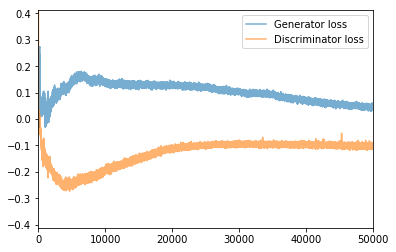

**** Iter 500    Val ROC 0.769, AP: 0.772, EO 0.008 ****
**** Iter 1000   Val ROC 0.781, AP: 0.779, EO 0.014 ****
**** Iter 1500   Val ROC 0.833, AP: 0.844, EO 0.027 ****
**** Iter 2000   Val ROC 0.863, AP: 0.870, EO 0.043 ****
2500   /50000    training iterations, took 1138 seconds so far...
**** Iter 2500   Val ROC 0.868, AP: 0.874, EO 0.053 ****
**** Iter 3000   Val ROC 0.854, AP: 0.863, EO 0.055 ****
**** Iter 3500   Val ROC 0.874, AP: 0.879, EO 0.051 ****
**** Iter 4000   Val ROC 0.878, AP: 0.884, EO 0.057 ****
**** Iter 4500   Val ROC 0.888, AP: 0.896, EO 0.063 ****
5000   /50000    training iterations, took 2317 seconds so far...
**** Iter 5000   Val ROC 0.885, AP: 0.895, EO 0.080 ****
**** Iter 5500   Val ROC 0.888, AP: 0.898, EO 0.082 ****
**** Iter 6000   Val ROC 0.884, AP: 0.899, EO 0.091 ****
**** Iter 6500   Val ROC 0.895, AP: 0.907, EO 0.102 ****
**** Iter 7000   Val ROC 0.886, AP: 0.900, EO 0.109 ****
7500   /50000    training iterations, took 3497 seconds so far...
****

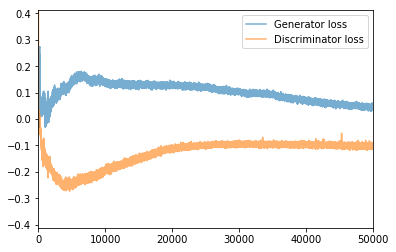

In [12]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping, eval_every=eval_every)

In [13]:
log_dict.keys()

dict_keys(['disc_losses', 'gen_losses', 'val_performances', 'edge_overlaps', 'generated_graphs'])

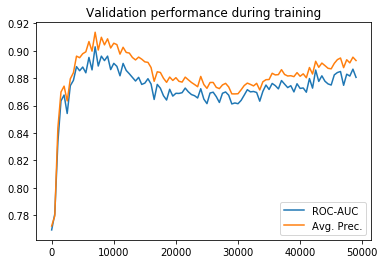

In [14]:
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
         np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
         np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

plt.title("Validation performance during training")
plt.legend()
plt.show()

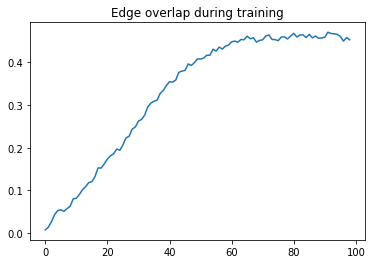

In [15]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [16]:
sample_many = netgan.generate_discrete(10000, reuse=True)

In [17]:
samples = []
for _ in range(600):
    samples.append(sample_many.eval({netgan.tau: 0.5}))

#### Assemble score matrix from the random walks

In [18]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()

#### Compute the test error on the held-out edges and non-edges (more relevant for VAL criterion)

In [19]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

In [20]:
roc_auc_score(test_labels, test_scores)

0.896434375

In [21]:
average_precision_score(test_labels, test_scores)

0.9095022760785608

#### Compute graph statistics (more relevant for EO criterion)

In [22]:
A_select = sp.csr_matrix((np.ones(len(train_ones)), (train_ones[:,0], train_ones[:,1])))

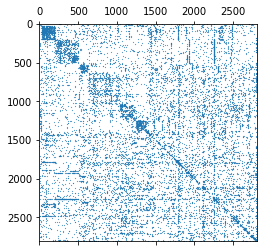

In [23]:
sampled_graph = utils.graph_from_scores(scores_matrix, A_select.sum())
plt.spy(sampled_graph, markersize=.2)
plt.show()

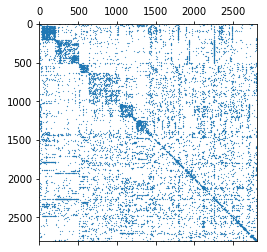

In [24]:
plt.spy(A_select, markersize=.2)
plt.show()

In [25]:
utils.compute_graph_statistics(sampled_graph)

/home/zuegnerd/anaconda3/envs/tf/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'LCC': 2810,
 'assortativity': -0.08970318795532255,
 'claw_count': 3052424.0,
 'clustering_coefficient': 0.0010231212963860853,
 'd': 4.8277580071174375,
 'd_max': 241.0,
 'd_min': 1.0,
 'gini': 0.4505477635894215,
 'n_components': 1,
 'power_law_exp': 1.8237074052198512,
 'rel_edge_distr_entropy': 0.947251282686368,
 'square_count': 41,
 'triangle_count': 1041,
 'wedge_count': 96508.0}

In [26]:
utils.compute_graph_statistics(A_select.toarray())

/home/zuegnerd/anaconda3/envs/tf/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'LCC': 2810,
 'assortativity': -0.07626405450439543,
 'claw_count': 3033514.0,
 'clustering_coefficient': 0.002771043746625201,
 'd': 4.8277580071174375,
 'd_max': 238.0,
 'd_min': 1.0,
 'gini': 0.481862548353299,
 'n_components': 1,
 'power_law_exp': 1.8550648593086239,
 'rel_edge_distr_entropy': 0.9406625947273197,
 'square_count': 457,
 'triangle_count': 2802,
 'wedge_count': 101747.0}